# Fig. 6: Noise decomposition for assessing loss of biological signal

In [176]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, 'src/')    # adds monod to path
sys.path.insert(0, 'functions/')

import monod
from monod import analysis

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

import copy

from getter_functions import get_raw_data, get_fits
from noise_decomp_functions import get_transformed_data, trans_logp1, trans_PF, trans_PCA, trans_umap, trans_PCAsep, get_CV_raw
from noise_decomp_functions import get_moments_modelbased, get_moments_empirical, get_noise_decomp_modelbased, get_noise_decomp_empirical
from noise_decomp_functions import get_noise_decomp_modelbased2, get_valid_gene_masks, get_noise_decomp_obs

from plotting_functions import plot_noise_weight_histograms, compare_noise_attributions, compare_triangles, plot_weight_differences, plot_lax_bounds
from plotting_functions import plot_noise_weight_histograms_overlaid, plot_noise_weight_histograms_overlaid_cc
from plotting_functions import plot_noise_weight_histograms_typevardemo, plot_noise_weight_histograms_techvardemo, plot_CV2_scatter
from plotting_functions import plot_lax_bounds_comp_mature, plot_lax_bounds_comp_NM

from plotting_functions import compare_triangles_mature

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Preliminaries

### Get pbmc data and fits

In [119]:
print('pbmc_v2')  # pbmc data, v2
    
dir_string = 'pbmcs_1k_v2_rerunTC/fits/gg_240715_029_pbmc_celltypes_1'
dset_string = 'pbmc_1k_v2_'
pooled_string = 'all'
celltype_names = ['Bcells', 'Monocytes', 'Tcells']
fit_string = 'Bursty_Poisson_1x1/grid_scan_results_upd.res'

# get raw data
S_N_v2, S_M_v2, S_N_cell_v2, S_M_cell_v2, pi_v2, dset_numbers_v2 = get_raw_data(dir_string, dset_string, pooled_string, celltype_names)
n_genes_v2 = dset_numbers_v2['n_genes']
n_cells_v2 = dset_numbers_v2['n_cells']
n_cell_types_v2 = dset_numbers_v2['n_cell_types']
print()

# get model fits
b_v2, beta_v2, gamma_v2, lamb_N_v2, lamb_M_v2 = get_fits(dir_string, dset_string, fit_string, celltype_names)

# ======================

print('pbmc_v3')  # pbmc data, v2
    
dir_string = 'pbmcs_1k_v2_rerunTC/fits/gg_221118_025_pbmc_celltypes_1'
dset_string = 'pbmc_10k_v3_'
pooled_string = 'all'
celltype_names = ['Bcells', 'Monocytes', 'Tcells']
fit_string = 'Bursty_Poisson_20x21/grid_scan_results_upd.res'

# get raw data
S_N_v3, S_M_v3, S_N_cell_v3, S_M_cell_v3, pi_v3, dset_numbers_v3 = get_raw_data(dir_string, dset_string, pooled_string, celltype_names)
n_genes_v3 = dset_numbers_v3['n_genes']
n_cells_v3 = dset_numbers_v3['n_cells']
n_cell_types_v3 = dset_numbers_v3['n_cell_types']
print()

# get model fits
b_v3, beta_v3, gamma_v3, lamb_N_v3, lamb_M_v3 = get_fits(dir_string, dset_string, fit_string, celltype_names)

pbmc_v2
Successfully obtained raw nascent and mature, pooled cell types.
n_genes: 2500
n_cells: 990
n_cell_types: 3

Extracting data from  Bcells  cells...
Extracting data from  Monocytes  cells...
Extracting data from  Tcells  cells...
Successfully obtained raw nascent and mature, organized by cell type.

number of cells of each type: [ 79. 328. 572.]
fraction of cells that are each type: [0.07979798 0.33131313 0.57777778]

Extracting model fits for  Bcells  cells...
Extracting model fits for  Monocytes  cells...
Extracting model fits for  Tcells  cells...
Successfully collected model fit objects.
Extracting best fit parameters for  Tcells  cells...
Extracting best fit parameters for  Tcells  cells...
Extracting best fit parameters for  Tcells  cells...
Successfully extracted best fit parameters for all cell types.
pbmc_v3
Successfully obtained raw nascent and mature, pooled cell types.
n_genes: 2500
n_cells: 11171
n_cell_types: 3

Extracting data from  Bcells  cells...
Extracting dat

In [12]:
dset_numbers_v2['gene_names']
dset_numbers_v3['gene_names']

array(['FAM76A', 'VPS13D', 'YIPF1', ..., 'P2RY8', 'PPP2R3B', 'DDX3X'],
      dtype='<U17')

### Get glut/GABA data and fits

In [120]:
print('glut')  # allen glut data
    
# glutamatergic neuron data
dir_string = 'monod_fit_package/gg_230328_026_allen_celltypes_1'  # specify location of data
dset_string = 'allen_B08_'
pooled_string = 'Glutamatergic'
celltype_names = ['L23IT','L5IT','L6IT','L56NP', 'L6CT', 'L6b']
fit_string = 'Bursty_Poisson_20x21/grid_scan_results_upd.res'

# get raw data
S_N_glut, S_M_glut, S_N_cell_glut, S_M_cell_glut, pi_glut, dset_numbers_glut = get_raw_data(dir_string, dset_string, pooled_string, celltype_names)
n_cells_glut = dset_numbers_glut['n_cells']
print()

# get model fits
b_glut, beta_glut, gamma_glut, lamb_N_glut, lamb_M_glut = get_fits(dir_string, dset_string, fit_string, celltype_names)

# ======================

print('gaba')  # allen gaba data
    
# GABAergic neuron data
dir_string = 'monod_gaba_fit_package/fits/gg_240715_029_allen_celltypes_1'
dset_string = 'allen_B08_'
pooled_string = 'GABAergic'
celltype_names = ['Lamp5', 'Pvalb', 'Sst', 'Vip']
fit_string = 'Bursty_Poisson_20x21/grid_scan_results_upd.res'

# get raw data
S_N_gaba, S_M_gaba, S_N_cell_gaba, S_M_cell_gaba, pi_gaba, dset_numbers_gaba = get_raw_data(dir_string, dset_string, pooled_string, celltype_names)
n_cells_gaba = dset_numbers_gaba['n_cells']
print()

# get model fits
b_gaba, beta_gaba, gamma_gaba, lamb_N_gaba, lamb_M_gaba = get_fits(dir_string, dset_string, fit_string, celltype_names)

gaba
Successfully obtained raw nascent and mature, pooled cell types.
n_genes: 2951
n_cells: 789
n_cell_types: 4

Extracting data from  Lamp5  cells...
Extracting data from  Pvalb  cells...
Extracting data from  Sst  cells...
Extracting data from  Vip  cells...
Successfully obtained raw nascent and mature, organized by cell type.

number of cells of each type: [191. 114. 270. 214.]
fraction of cells that are each type: [0.24207858 0.14448669 0.34220532 0.2712294 ]

Extracting model fits for  Lamp5  cells...
Extracting model fits for  Pvalb  cells...
Extracting model fits for  Sst  cells...
Extracting model fits for  Vip  cells...
Successfully collected model fit objects.
Extracting best fit parameters for  Vip  cells...
Extracting best fit parameters for  Vip  cells...
Extracting best fit parameters for  Vip  cells...
Extracting best fit parameters for  Vip  cells...
Successfully extracted best fit parameters for all cell types.


### Pool GABA and glut data/fits

In [17]:
print(dset_numbers_glut['gene_names'])
print(dset_numbers_gaba['gene_names'])
num_genes = len(dset_numbers_glut['gene_names'])

# ensure same genes are  present in same order
assert [dset_numbers_glut['gene_names'][i] == dset_numbers_gaba['gene_names'][i] for i in range(num_genes)]

['AC149090.1' 'Ncstn' 'Brinp2' ... 'Kantr' '5330434G04Rik' 'Gm47283']
['AC149090.1' 'Ncstn' 'Brinp2' ... 'Kantr' '5330434G04Rik' 'Gm47283']


In [32]:
S_N_pool = np.concatenate( (S_N_glut, S_N_gaba), axis=1 )
S_M_pool = np.concatenate( (S_M_glut, S_M_gaba), axis=1 )
S_N_cell_pool = S_N_cell_glut + S_N_cell_gaba
S_M_cell_pool = S_M_cell_glut + S_M_cell_gaba

pi_pool = np.concatenate( ((n_cells_glut/(n_cells_glut + n_cells_gaba))*pi_glut , (n_cells_gaba/(n_cells_glut + n_cells_gaba))*pi_gaba), axis=0 )

b_pool = np.concatenate( (b_glut, b_gaba), axis=0 )
beta_pool = np.concatenate( (beta_glut, beta_gaba), axis=0 )
gamma_pool = np.concatenate( (gamma_glut, gamma_gaba), axis=0 )

lamb_N_pool = np.concatenate( (lamb_N_glut, lamb_N_gaba), axis=0 )
lamb_M_pool = np.concatenate( (lamb_M_glut, lamb_M_gaba), axis=0 )

In [39]:
lamb_N_gaba.shape

(4, 2951)

In [10]:
savedir = 'results/normalization/'

## 1. Noise decomposition consistent with intuition

### v2 noisier than v3

In [127]:
mom_model_v2, mom_cell_model_v2 = get_moments_modelbased(pi_v2, b_v2, beta_v2, gamma_v2)
V_model_v2, f_model_v2 = get_noise_decomp_modelbased2(mom_cell_model_v2, pi_v2, [lamb_N_v2, lamb_M_v2])

mom_model_v3, mom_cell_model_v3 = get_moments_modelbased(pi_v3, b_v3, beta_v3, gamma_v3)
V_model_v3, f_model_v3 = get_noise_decomp_modelbased2(mom_cell_model_v3, pi_v3, [lamb_N_v3, lamb_M_v3])

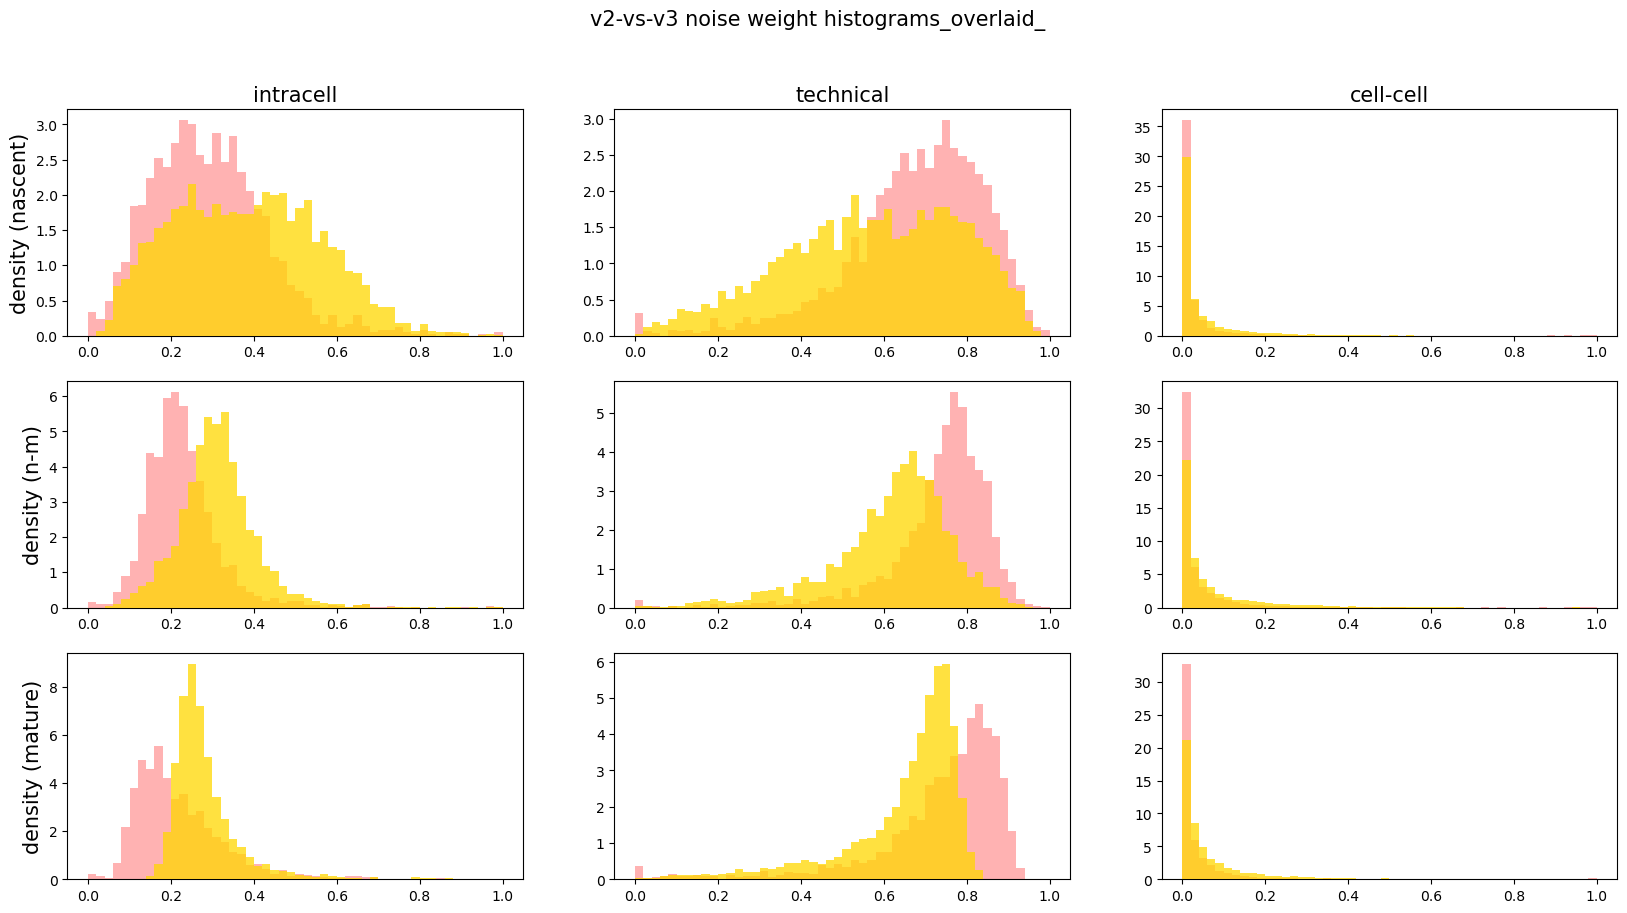

In [8]:
plot_noise_weight_histograms_overlaid(f_model_v2, f_model_v3, name='v2-vs-v3', savedir=savedir)

In [126]:
f_model_v2

{'f_intra_N': array([[0.3701545 , 0.34918226, 0.09345566, ..., 0.35374201, 0.39020287,
         0.55311951],
        [0.3701545 , 0.34918226, 0.09345566, ..., 0.35374201, 0.39020287,
         0.55311951],
        [0.3701545 , 0.34918226, 0.09345566, ..., 0.35374201, 0.39020287,
         0.55311951]]),
 'f_cell_N': array([[0.00140008, 0.00052618, 0.00392259, ..., 0.00103157, 0.12704692,
         0.01073657],
        [0.00140008, 0.00052618, 0.00392259, ..., 0.00103157, 0.12704692,
         0.01073657],
        [0.00140008, 0.00052618, 0.00392259, ..., 0.00103157, 0.12704692,
         0.01073657]]),
 'f_tech_N': array([[0.62844542, 0.65029156, 0.90262175, ..., 0.64522641, 0.48275021,
         0.43614392],
        [0.62844542, 0.65029156, 0.90262175, ..., 0.64522641, 0.48275021,
         0.43614392],
        [0.62844542, 0.65029156, 0.90262175, ..., 0.64522641, 0.48275021,
         0.43614392]]),
 'f_intra_NM': array([[0.15035863, 0.28411684, 0.12353346, ..., 0.36396131, 0.2274719 ,
     

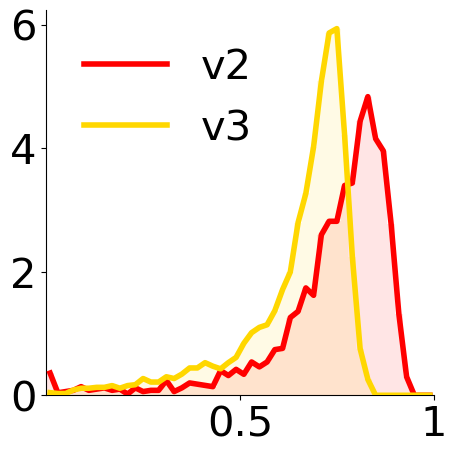

In [144]:
plot_noise_weight_histograms_techvardemo([f_model_v2, f_model_v3], name='v2-vs-v3', savedir=savedir)

### glut + GABA has more cell-cell variation than glut only and GABA only

In [124]:
n_gaba_types = dset_numbers_gaba['n_cell_types']
f_model_gaba_ = []

for i in range(1,n_gaba_types+1):
    pi_gaba_ = pi_gaba[:i]/np.sum(pi_gaba[:i])
    _, mom_cell_model_gaba = get_moments_modelbased(pi_gaba_, b_gaba[:i,:], beta_gaba[:i,:], gamma_gaba[:i,:])
    _, f_model_gaba = get_noise_decomp_modelbased2(mom_cell_model_gaba, pi_gaba_, [lamb_N_gaba[:i,:], lamb_M_gaba[:i,:]])
    f_model_gaba_.append(f_model_gaba)

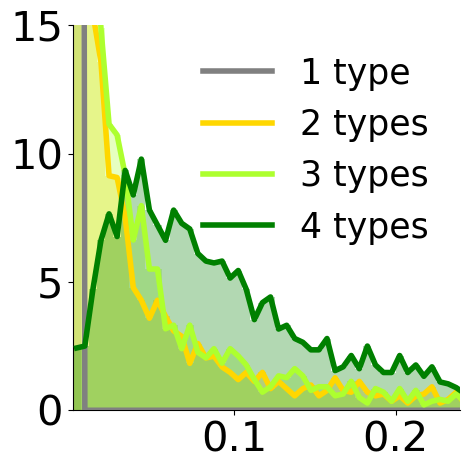

In [143]:
plot_noise_weight_histograms_typevardemo(f_model_gaba_, name='gaba-vs-gaba', savedir=savedir)

## 2. Denoising interpretation is reasonable

### Get glut data

In [2]:
print('glut')  # allen glut data
    
# glutamatergic neuron data
dir_string = 'monod_fit_package/gg_230328_026_allen_celltypes_1'  # specify location of data
dset_string = 'allen_B08_'
pooled_string = 'Glutamatergic'
celltype_names = ['L23IT','L5IT','L6IT','L56NP', 'L6CT', 'L6b']
fit_string = 'Bursty_Poisson_20x21/grid_scan_results_upd.res'

# get raw data
S_N, S_M, S_N_cell, S_M_cell, pi, dset_numbers = get_raw_data(dir_string, dset_string, pooled_string, celltype_names)
n_cells = dset_numbers['n_cells']
print()

# get model fits
b, beta, gamma, lamb_N_cell, lamb_M_cell = get_fits(dir_string, dset_string, fit_string, celltype_names)

glut
Successfully obtained raw nascent and mature, pooled cell types.
n_genes: 2951
n_cells: 5343
n_cell_types: 6

Extracting data from  L23IT  cells...
Extracting data from  L5IT  cells...
Extracting data from  L6IT  cells...
Extracting data from  L56NP  cells...
Extracting data from  L6CT  cells...
Extracting data from  L6b  cells...
Successfully obtained raw nascent and mature, organized by cell type.

number of cells of each type: [ 823. 2382.  489.  250. 1333.   66.]
fraction of cells that are each type: [0.15403331 0.44581696 0.09152162 0.04679019 0.24948531 0.01235261]

Extracting model fits for  L23IT  cells...
Extracting model fits for  L5IT  cells...
Extracting model fits for  L6IT  cells...
Extracting model fits for  L56NP  cells...
Extracting model fits for  L6CT  cells...
Extracting model fits for  L6b  cells...
Successfully collected model fit objects.
Extracting best fit parameters for  L6b  cells...
Extracting best fit parameters for  L6b  cells...
Extracting best fit p

### Transform raw data

In [3]:
S = [S_N, S_M]
S_cell = [S_N_cell, S_M_cell]

# Setup for transformed data; uses summed nascent and mature, pooled cell types ====
S_sum = S_N + S_M

C_S = S_sum.sum(0).mean(); params_PF = {'C_S':C_S}   # setup for PF
S_sum_PF = C_S*S_sum*(1/(S_sum.sum(0))[None,:])

S_sum_logp1 = np.log(1 + S_sum_PF)

n_PCA_comps = 50
pca_transformer = PCA(n_components=n_PCA_comps)
pca_transformer.fit(S_sum_logp1.T); params_PCA = {'pca_transformer':pca_transformer}
S_PCA_50D = pca_transformer.transform(S_sum_logp1.T).T

print('starting umap...')
umap_transformer = umap.UMAP()
umap_transformer.fit(S_PCA_50D.T)
params_umap = {'umap_transformer':umap_transformer, 'pca_transformer':pca_transformer}
print('Finished all setup!')

starting umap...
Finished all setup!


In [4]:
# Get transformed data ==================
S_PF, S_cell_PF = get_transformed_data(S, S_cell, trans_PF, params_PF)                  # PF
S_logp1, S_cell_logp1 = get_transformed_data(S_PF, S_cell_PF, trans_logp1)              # logp1
S_PCA, S_cell_PCA = get_transformed_data(S_logp1, S_cell_logp1, trans_PCA, params_PCA)  # PCA

In [5]:
# WARNING: TAKES A LONG TIME AT LEAST ON MY COMPUTER -> MAYBE 5-10 MIN?
S_umap, S_cell_umap = get_transformed_data(S_logp1, S_cell_logp1, trans_umap, params_umap)

(50, 5343)
(5343, 2)
(50, 823)
(823, 2)
(50, 2382)
(2382, 2)
(50, 489)
(489, 2)
(50, 250)
(250, 2)
(50, 1333)
(1333, 2)
(50, 66)
(66, 2)


In [16]:
# additional data transforms, just for fun
S_logp1only, S_cell_logp1only = get_transformed_data(S, S_cell, trans_logp1)   # logp1 only

# PCA only
S_sum_raw = S[0] + S[1]; n_PCA_comps = 50
pca_transformer_raw = PCA(n_components=n_PCA_comps)
pca_transformer_raw.fit(S_sum_raw.T); params_PCA_raw = {'pca_transformer':pca_transformer_raw}
S_PCA_50D_raw = pca_transformer_raw.transform(S_sum_raw.T).T
S_PCAonly, S_cell_PCAonly = get_transformed_data(S, S_cell, trans_PCA, params_PCA_raw)

# PCA only, nascent and mature treated separately
pca_transformer_N = PCA(n_components=n_PCA_comps); pca_transformer_M = PCA(n_components=n_PCA_comps)
pca_transformer_N.fit(S_N.T); pca_transformer_M.fit(S_M.T); 
params_PCA_sep = {'pca_transformer_N':pca_transformer_N, 'pca_transformer_M':pca_transformer_M}
S_PCAsep, S_cell_PCAsep = get_transformed_data(S, S_cell, trans_PCAsep, params_PCA_sep)

In [17]:
print('starting umap...')
umap_transformer_raw = umap.UMAP()
umap_transformer_raw.fit(S_PCA_50D_raw.T)
params_umap_raw = {'umap_transformer':umap_transformer_raw, 'pca_transformer':pca_transformer_raw}
print('Finished all setup!')

starting umap...
Finished all setup!


In [18]:
# WARNING: TAKES A LONG TIME AT LEAST ON MY COMPUTER -> MAYBE 5-10 MIN?
S_umaponly, S_cell_umaponly = get_transformed_data(S, S_cell, trans_umap, params_umap_raw)

(50, 5343)
(5343, 2)
(50, 823)
(823, 2)
(50, 2382)
(2382, 2)
(50, 489)
(489, 2)
(50, 250)
(250, 2)
(50, 1333)
(1333, 2)
(50, 66)
(66, 2)


### Get moments

In [19]:
# get moments, empirical
mom_raw, mom_cell_raw = get_moments_empirical(S, S_cell)

mom_PF, mom_cell_PF = get_moments_empirical(S_PF, S_cell_PF)
mom_logp1, mom_cell_logp1 = get_moments_empirical(S_logp1, S_cell_logp1)
mom_PCA, mom_cell_PCA = get_moments_empirical(S_PCA, S_cell_PCA)
mom_umap, mom_cell_umap = get_moments_empirical(S_umap, S_cell_umap)

mom_logp1only, mom_cell_logp1only = get_moments_empirical(S_logp1only, S_cell_logp1only)
mom_PCAonly, mom_cell_PCAonly = get_moments_empirical(S_PCAonly, S_cell_PCAonly)
mom_PCAsep, mom_cell_PCAsep = get_moments_empirical(S_PCAsep, S_cell_PCAsep)
mom_umaponly, mom_cell_umaponly = get_moments_empirical(S_umaponly, S_cell_umaponly)

# get moments, model-based
mom_model, mom_cell_model = get_moments_modelbased(pi, b, beta, gamma)

## ID high expression genes

In [39]:
# ID top 95% expression by mean; use summed nascent and mature means to measure this
_, mu_M_raw, _, _, _ = mom_raw 
cutoff = np.quantile(mu_M_raw, 0.95)   # get 95th quantile

mask = (mu_M_raw >= cutoff)

### Plot CV2

PF
64.07997289054558 % of genes were denoised
log1p
100.0 % of genes were denoised
PCA
100.0 % of genes were denoised
UMAP
99.93222636394442 % of genes were denoised


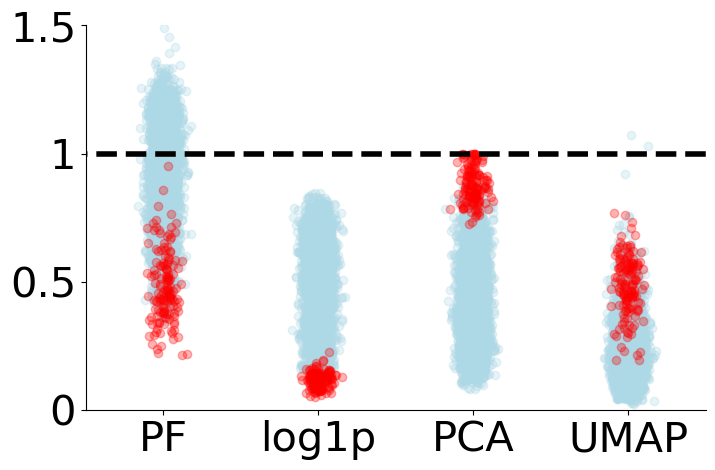

In [149]:
#mom_list = [mom_raw, mom_PF, mom_logp1, mom_PCA, mom_umap]
mom_list = [mom_raw, mom_PF, mom_logp1only, mom_PCAsep, mom_umaponly]
labels = ['raw', 'PF', 'log1p', 'PCA', 'UMAP']
plot_CV2_scatter(mom_list, labels, mask, savedir=savedir)

## 3. More processing, more noise effectively attributed to technical effects

In [67]:
# get noise decompositions
V_model, f_model = get_noise_decomp_modelbased2(mom_cell_model, pi, [lamb_N_cell, lamb_M_cell])

V_raw = get_CV_raw(mom_raw)
V_PF, f_PF = get_noise_decomp_empirical(mom_raw, mom_PF, mom_cell_PF, pi)
V_logp1, f_logp1 = get_noise_decomp_empirical(mom_raw, mom_logp1, mom_cell_logp1, pi)
V_PCA, f_PCA = get_noise_decomp_empirical(mom_raw, mom_PCA, mom_cell_PCA, pi)
V_umap, f_umap = get_noise_decomp_empirical(mom_raw, mom_umap, mom_cell_umap, pi)

V_logp1only, f_logp1only = get_noise_decomp_empirical(mom_raw, mom_logp1only, mom_cell_logp1only, pi)
V_PCAonly, f_PCAonly = get_noise_decomp_empirical(mom_raw, mom_PCAonly, mom_cell_PCAonly, pi)
V_PCAsep, f_PCAsep = get_noise_decomp_empirical(mom_raw, mom_PCAsep, mom_cell_PCAsep, pi)
V_umaponly, f_umaponly = get_noise_decomp_empirical(mom_raw, mom_umaponly, mom_cell_umaponly, pi)

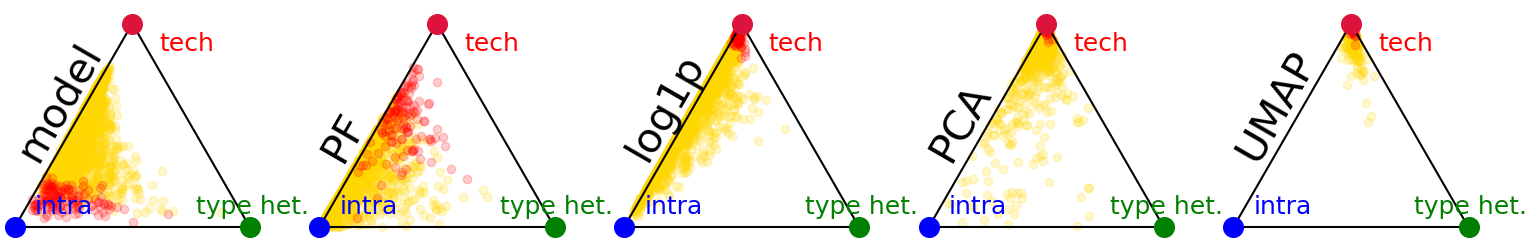

In [150]:
f_list = [f_model, f_PF, f_logp1, f_PCA, f_umap]
mom_list = [mom_raw, mom_PF, mom_logp1, mom_PCA, mom_umap]
labels = ['model', 'PF', 'log1p', 'PCA', 'UMAP']

masks = get_valid_gene_masks(mom_list)   # for decomp to make sense, need CV_N_raw > CV_N_trans, CV_M_raw > CV_M_trans
compare_triangles_mature(f_list, labels, masks, high_mask=mask, savedir=savedir)

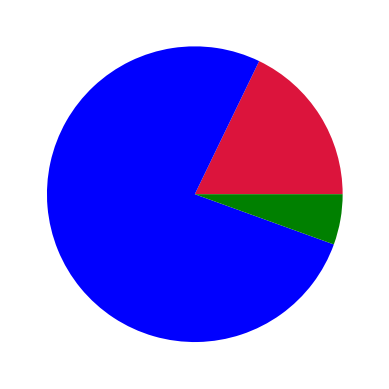

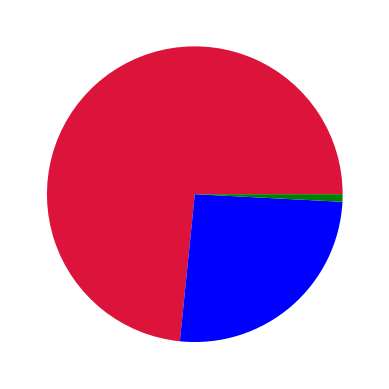

In [118]:
id = 0
colors = ['crimson', 'blue', 'green']
formats = ['.png', '.svg', '.pdf']

f_model_tech, f_model_intra, f_model_type = f_model['f_tech_M'][id], f_model['f_intra_M'][id], f_model['f_cell_M'][id]
f_trans_tech, f_trans_intra, f_trans_type = f_logp1only['f_tech_M'][id], f_logp1only['f_intra_M'][id], f_logp1only['f_cell_M'][id]


fig, ax = plt.subplots()
ax.pie([f_model_tech, f_model_intra, f_model_type], colors=colors)
for f in formats:
    plt.savefig(savedir+'piechart_model'+f,bbox_inches='tight', transparent=True)
plt.show()

fig, ax = plt.subplots()
ax.pie([f_trans_tech, f_trans_intra, f_trans_type], colors=colors)
for f in formats:
    plt.savefig(savedir+'piechart_trans'+f,bbox_inches='tight', transparent=True)
plt.show()

## 4. Model-free bounds

In [164]:
V_obs, f_obs = get_noise_decomp_obs(mom_raw, mom_cell_raw, pi)

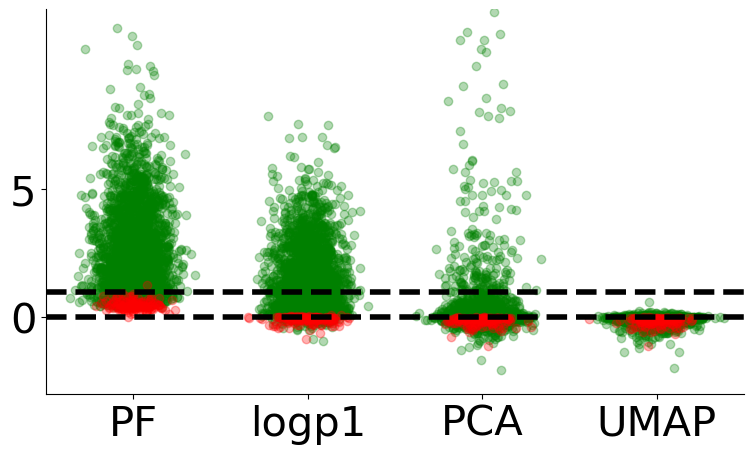

In [186]:
V_list = [V_PF, V_logp1, V_PCA, V_umap]
labels = ['PF', 'logp1', 'PCA', 'UMAP']
plot_lax_bounds_comp_mature(V_obs, V_list, labels, mask, name='', savedir=savedir)

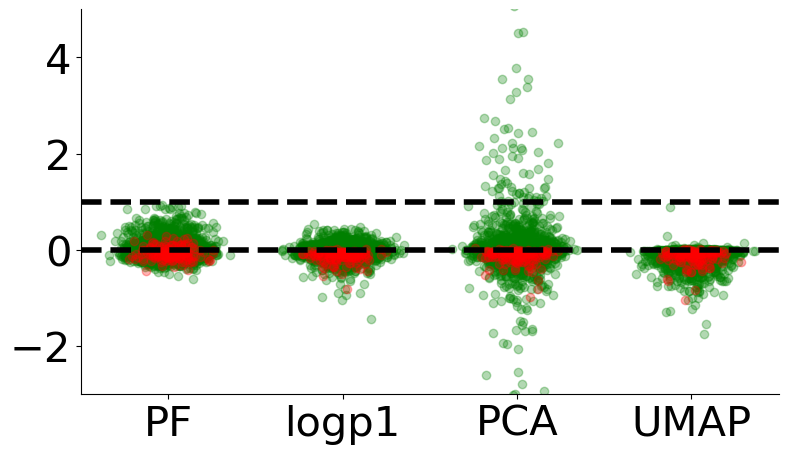

In [184]:
plot_lax_bounds_comp_NM(V_obs, V_list, labels, mask, name='', savedir=savedir)